# Explore here

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

df= pd.read_csv(r"https://raw.githubusercontent.com/4GeeksAcademy/data-preprocessing-project-tutorial/main/AB_NYC_2019.csv").iloc[:,1:]
pd.set_option('display.max_columns', None)
df

,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365
0,Clean & quiet apt home by the park,2787,John,Brooklyn,Kensington,40.64749,-73.97237,Private room,149,1,9,2018-10-19,0.21,6,365
1,Skylit Midtown Castle,2845,Jennifer,Manhattan,Midtown,40.75362,-73.98377,Entire home/apt,225,1,45,2019-05-21,0.38,2,355
2,THE VILLAGE OF HARLEM....NEW YORK !,4632,Elisabeth,Manhattan,Harlem,40.80902,-73.94190,Private room,150,3,0,NaN,NaN,1,365
3,Cozy Entire Floor of Brownstone,4869,LisaRoxanne,Brooklyn,Clinton Hill,40.68514,-73.95976,Entire home/apt,89,1,270,2019-07-05,4.64,1,194
4,Entire Apt: Spacious Studio/Loft by central park,7192,Laura,Manhattan,East Harlem,40.79851,-73.94399,Entire home/apt,80,10,9,2018-11-19,0.10,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48890,Charming one bedroom - newly renovated rowhouse,8232441,Sabrina,Brooklyn,Bedford-Stuyvesant,40.67853,-73.94995,Private room,70,2,0,NaN,NaN,2,9
48891,Affordable room in Bushwick/East Williamsburg,6570630,Marisol,Brooklyn,Bushwick,40.70184,-73.93317,Private room,40,4,0,NaN,NaN,2,36
48892,Sunny Studio at Historical Neighborhood,23492952,Ilgar & Aysel,Manhattan,Harlem,40.81475,-73.94867,Entire home/apt,115,10,0,NaN,NaN,1,27
48893,43rd St. Time Square-cozy single bed,30985759,Taz,Manhattan,Hell's Kitchen,40.75751,-73.99112,Shared room,55,1,0,NaN,NaN,6,2


In [4]:
df.shape

(48895, 15)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48895 entries, 0 to 48894
Data columns (total 15 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   name                            48879 non-null  object 
 1   host_id                         48895 non-null  int64  
 2   host_name                       48874 non-null  object 
 3   neighbourhood_group             48895 non-null  object 
 4   neighbourhood                   48895 non-null  object 
 5   latitude                        48895 non-null  float64
 6   longitude                       48895 non-null  float64
 7   room_type                       48895 non-null  object 
 8   price                           48895 non-null  int64  
 9   minimum_nights                  48895 non-null  int64  
 10  number_of_reviews               48895 non-null  int64  
 11  last_review                     38843 non-null  object 
 12  reviews_per_month               

In [6]:
df.nunique()

name                              47905
host_id                           37457
host_name                         11452
neighbourhood_group                   5
neighbourhood                       221
latitude                          19048
longitude                         14718
room_type                             3
price                               674
minimum_nights                      109
number_of_reviews                   394
last_review                        1764
reviews_per_month                   937
calculated_host_listings_count       47
availability_365                    366
dtype: int64

In [7]:
df.drop(['room_type', 'calculated_host_listings_count'], axis=1, inplace=True)

In [8]:
df.duplicated().sum()

0

In [9]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
host_id,48895.0,6.762001e+07,7.861097e+07,2438.00000,7.822033e+06,3.079382e+07,1.074344e+08,2.743213e+08
latitude,48895.0,4.072895e+01,5.453008e-02,40.49979,4.069010e+01,4.072307e+01,4.076311e+01,4.091306e+01
longitude,48895.0,-7.395217e+01,4.615674e-02,-74.24442,-7.398307e+01,-7.395568e+01,-7.393627e+01,-7.371299e+01
price,48895.0,1.527207e+02,2.401542e+02,0.00000,6.900000e+01,1.060000e+02,1.750000e+02,1.000000e+04
minimum_nights,48895.0,7.029962e+00,2.051055e+01,1.00000,1.000000e+00,3.000000e+00,5.000000e+00,1.250000e+03
number_of_reviews,48895.0,2.327447e+01,4.455058e+01,0.00000,1.000000e+00,5.000000e+00,2.400000e+01,6.290000e+02
reviews_per_month,38843.0,1.373221e+00,1.680442e+00,0.01000,1.900000e-01,7.200000e-01,2.020000e+00,5.850000e+01
availability_365,48895.0,1.127813e+02,1.316223e+02,0.00000,0.000000e+00,4.500000e+01,2.270000e+02,3.650000e+02


In [10]:
df1 = df[['neighbourhood_group', 'price']]
df1

,neighbourhood_group,price
0,Brooklyn,149
1,Manhattan,225
2,Manhattan,150
3,Brooklyn,89
4,Manhattan,80
...,...,...
48890,Brooklyn,70
48891,Brooklyn,40
48892,Manhattan,115
48893,Manhattan,55


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


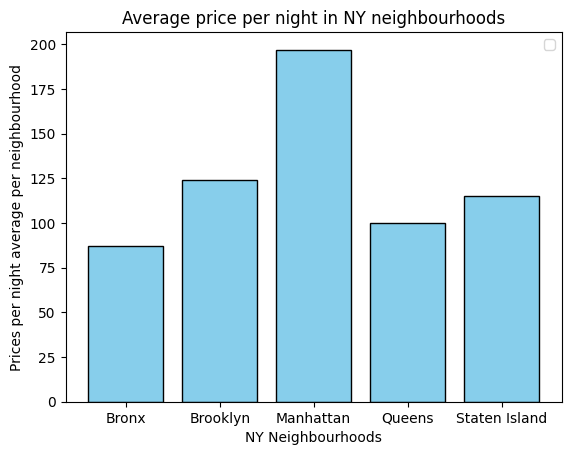

In [16]:
#Medias de los precios por noche de cada vecindario
import matplotlib.pyplot as plt

price_bronx = df1.loc[df['neighbourhood_group']== 'Bronx', 'price'].mean().round()
price_brooklyn = df1.loc[df['neighbourhood_group']== 'Brooklyn', 'price'].mean().round()
price_manhattan = df1.loc[df['neighbourhood_group']== 'Manhattan', 'price'].mean().round()
price_queens = df1.loc[df['neighbourhood_group']== 'Queens', 'price'].mean().round()
price_statenisland = df1.loc[df['neighbourhood_group']== 'Staten Island', 'price'].mean().round()

#Valores adicionales a mostrar en el plot
x = [0,1,2,3,4]
xlabels = ['Bronx', 'Brooklyn', 'Manhattan', 'Queens', 'Staten Island']
xvalues = [price_bronx, price_brooklyn, price_manhattan, price_queens, price_statenisland]
plt_lenght = np.arange(len(x))

plt.bar(plt_lenght, xvalues, color='skyblue', edgecolor='black', align='center')
plt.xlabel('NY Neighbourhoods')
plt.ylabel('Prices per night average per neighbourhood')
plt.title('Average price per night in NY neighbourhoods')
plt.xticks(x, xlabels)
plt.legend()
plt.show()


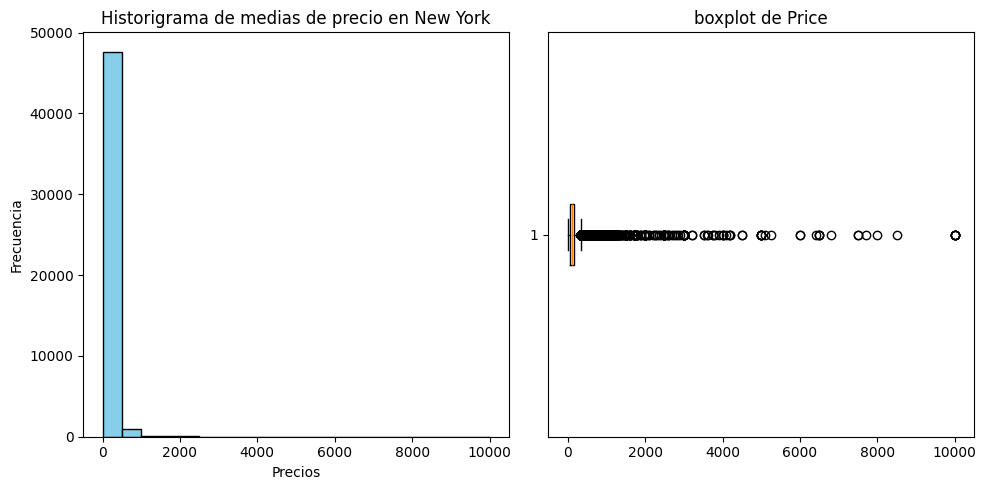

In [12]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1,2, figsize=(10,5))

ax[0].hist(df['price'], bins=20, color='skyblue', edgecolor='black')
ax[0].set_title('Historigrama de medias de precio en New York')
ax[0].set_xlabel('Precios')
ax[0].set_ylabel('Frecuencia')

ax[1].boxplot(df['price'], vert=False)
ax[1].set_title('boxplot de Price')
ax[1].set_label('Precio')

plt.tight_layout()
plt.show()

In [20]:
df['log_price'] = np.log(df.price)

/home/vscode/.local/lib/python3.10/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


ValueError: supplied range of [-inf, 9.210340371976184] is not finite

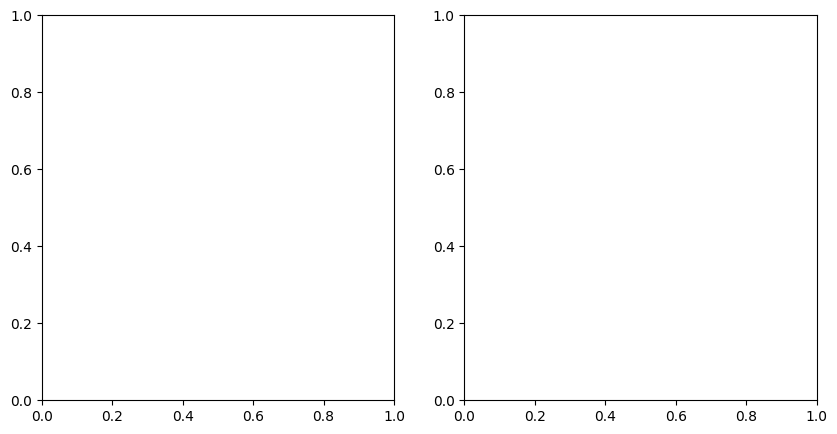

In [24]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1,2, figsize=(10,5))

ax[0].hist(df['log_price'], bins=20, color='blue', edgecolor='black')
ax[0].set_title('Historigrama de medias de precio en New York')
ax[0].set_xlabel('Precios')
ax[0].set_ylabel('Frecuencia')

ax[1].boxplot(df['log_price'], vert=False)
ax[1].set_title('boxplot de Price')
ax[1].set_label('Precio')

plt.tight_layout()
plt.show()